<h1><center>Emma Grandgirard - M2 SID<span class="tocSkip"></span>
<h4><center>MSA - Travail à rendre n°1<span class="tocSkip"></span>

L'objectif de ce TP est d'identifier les facteurs de risque maternels associés à un faible poids du bébé à la naissance. On cherchera à déterminer les variables ou facteurs pouvant influencer ce poids, donné par la variable `pdsb`. On dispose de :

- `age` : âge de la mère ;

- `pdsm` : poids de la mère ;

- `race`: race de la mère ;

- `tabac`: tabagisme de la mère au cours de la grossesse ;

- `aap`: antécédent d'accouchement prématuré chez la mère ;

-  `ht` : présence d'hypertension chez la mère ;

- `iu` : présence d'irritabilité utérine chez la mère ;

- `nbv` : nombre de visites médicales de la mère au cours du premier trimestre.

On commencera par une analyse descriptive, avant de mettre en oeuvre différents modèles : ANOVA, régression linéaire multiple, puis ANCOVA.

In [1]:
library('Hmisc')
library('HH')

In [2]:
options(warn=-1)
babyweight <- read.csv('babyweight.csv', sep='')
cat(paste(dim(babyweight)[1], 'observations,', dim(babyweight)[2], 'variables :\n'))
cat(names(babyweight))

189 observations, 10 variables :
id age pdsm race tabac aap ht iu nbv pdsb

In [3]:
# Processing
rownames(babyweight) <- babyweight$id  # id = index
babyweight <- babyweight[-c(1)]
babyweight$aap[babyweight$aap >= 2] = 2  # recode
babyweight$nbv[babyweight$nbv >= 3] = 3  # recode
attach(babyweight)

expl_vars <- c('age', 'pdsm', 'race', 'tabac', 'ht', 'iu', 'aap', 'nbv')  # explanatory variables
num_vars <- c('age', 'pdsm')  # numeric
fact_vars <- setdiff(expl_vars, num_vars)  # categorical

# Convert to factors
for(var in fact_vars){
    babyweight[, var] <- as.factor(babyweight[, var])
}

Note : étant donné que le niveau 3 du facteur `aap` ne contient qu'une seule observation, et que les autres niveaux sont 0, 1 et 2, on remplace le niveau 2 par un niveau 2 ou plus. De même, on regroupe les niveaux 3 et plus de `nbv` en un seul niveau.

# Analyse descriptive simple

## Résumé

In [4]:
summary(babyweight)

      age             pdsm        race   tabac   aap     ht      iu     
 Min.   :14.00   Min.   : 40.00   1:96   0:115   0:159   0:177   0:161  
 1st Qu.:19.00   1st Qu.: 55.00   2:26   1: 74   1: 24   1: 12   1: 28  
 Median :23.00   Median : 60.50   3:67           2:  6                  
 Mean   :23.24   Mean   : 64.91                                         
 3rd Qu.:26.00   3rd Qu.: 70.00                                         
 Max.   :45.00   Max.   :125.00                                         
 nbv          pdsb     
 0:100   Min.   : 709  
 1: 47   1st Qu.:2414  
 2: 30   Median :2977  
 3: 12   Mean   :2945  
         3rd Qu.:3475  
         Max.   :4990  

On dispose de 189 observations. On a converti les variables catégorielles en facteurs (classe `factor`). 
<br>
Concernant les variables explicatives, on peut voir notamment que 39.15% des mères ont consommé du tabac pendant leur grossesse (`tabac`). De plus, on note la présence d'hypertension (`ht`) chez 6.35% des mères, la présence d'irritabilité utérine (`iu`) chez 14.81% des mères, et des antécédents d'accouchement prématuré (`aat`) chez 15.87% des mères.

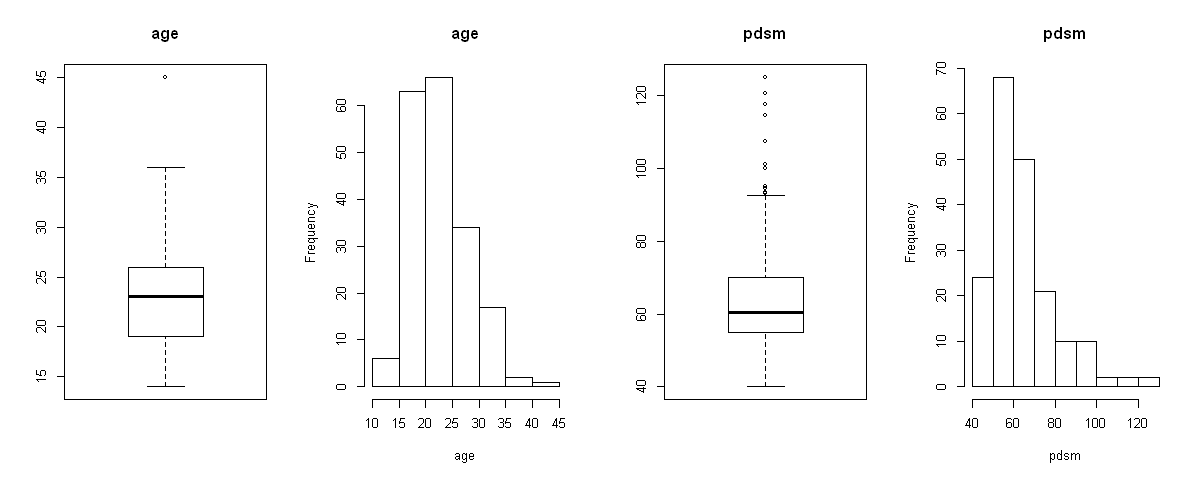

In [5]:
# Numeric variables distribution
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow=c(1, 4))

for(var in num_vars){
    boxplot(babyweight[, var], main=toString(var))
    hist(babyweight[, var], main=toString(var), xlab=var)
}

<br>Concernant les variables explicatives numériques, on peut noter que `age` et `pdsm` ont une médiane proche de leur moyenne.
<br>Les deux variables sont assez dispersées : `age` s'étend de 14 à 45 ans, et `pdsm` de 40 à 125 kg. 

## Variable réponse

La variable réponse est le poids du bébé `pdsb`. Le poids minimum est très bas : 709g, tandis que le poids maximum est de 4990g. Les bébés ont un poids moyen de 2945g.


	Shapiro-Wilk normality test

data:  pdsb
W = 0.99247, p-value = 0.4383


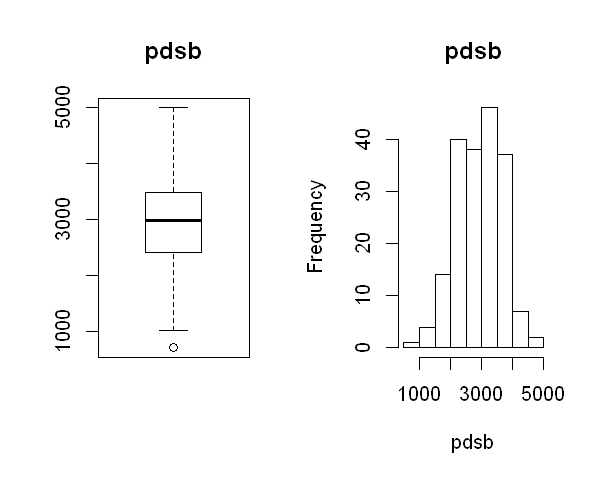

In [6]:
options(repr.plot.width=5, repr.plot.height=4)
par(mfrow=c(1, 2))
boxplot(babyweight[, 'pdsb'], main=toString('pdsb'))
hist(babyweight[, 'pdsb'], main=toString('pdsb'), xlab='pdsb')
shapiro.test(pdsb)

Le test de Shapiro-Wilk renvoie une p-value non significative (supérieure à 0,05). La distribution de la variable réponse est donc supposée gaussienne. Dans ce cas précis, la gaussianité de la variable réponse n'est pas obligatoire ; elle le serait si l'on souhaitait mettre en oeuvre un modèle linéaire sur un échantillon plus petit (30 observations ou moins).

## Plan d'expérience

In [7]:
# Pivot table of factors
table(aap, ht, iu, race, tabac, nbv)  # not displayed on the PDF file (too long)

, , iu = 0, race = 1, tabac = 0, nbv = 0

   ht
aap  0  1
  0 13  0
  1  0  0
  2  0  0

, , iu = 1, race = 1, tabac = 0, nbv = 0

   ht
aap  0  1
  0  0  0
  1  0  0
  2  0  0

, , iu = 0, race = 2, tabac = 0, nbv = 0

   ht
aap  0  1
  0  4  2
  1  0  0
  2  0  0

, , iu = 1, race = 2, tabac = 0, nbv = 0

   ht
aap  0  1
  0  2  0
  1  0  0
  2  0  0

, , iu = 0, race = 3, tabac = 0, nbv = 0

   ht
aap  0  1
  0 26  2
  1  1  1
  2  0  0

, , iu = 1, race = 3, tabac = 0, nbv = 0

   ht
aap  0  1
  0  4  0
  1  0  0
  2  0  0

, , iu = 0, race = 1, tabac = 1, nbv = 0

   ht
aap  0  1
  0 16  2
  1  4  0
  2  1  0

, , iu = 1, race = 1, tabac = 1, nbv = 0

   ht
aap  0  1
  0  4  0
  1  1  0
  2  2  0

, , iu = 0, race = 2, tabac = 1, nbv = 0

   ht
aap  0  1
  0  4  1
  1  1  0
  2  0  0

, , iu = 1, race = 2, tabac = 1, nbv = 0

   ht
aap  0  1
  0  0  0
  1  0  0
  2  0  0

, , iu = 0, race = 3, tabac = 1, nbv = 0

   ht
aap  0  1
  0  3  0
  1  1  0
  2  1  0

, , iu = 1, race = 3,

Le plan d'expérience n'est pas complet. Cela signifie que le modèle d'analyse de variance expliquant le poids du bébé en fonction de ces 6 facteurs ne pourra contenir que les effets propres de chaque facteur (modèle additif). On ne pourra donc prendre en compte aucune interaction.

On s'intéressera d'abord séparément aux variables catégorielles et aux variables numériques : 

- Pour les variables catégorielles, on mettra en oeuvre une ANOVA par facteur puis un modèle additif (sans interaction) pour l'ANOVA (partie 2) ;

- Pour les variables numériques, on observera d'abord les corrélations puis on réalisera une régression linéaire (partie 3).

<br>
Enfin, en partie 4, on mettra en oeuvre une ou plusieurs ANCOVA, ce qui nous permettra de prendre en compte à la fois une variable numérique et un facteur. Pour cette partie on utilisera les variables identifiées comme ayant un effet significatif sur `pdsb` dans les parties 2 et 3.

# Facteurs

## Analyses descriptives et ANOVA à un facteur

Etant donné le caractère non-complet du plan d'expérience, le modèle factoriel ne pourra contenir que les effets propres de chaque facteur.
<br>
Tout d'abord, on étudie l'effet de chaque facteur sur le poids du bébé, en mettant en oeuvre plusieurs ANOVA à un facteur et en observant la distribution de `pdsb` selon chaque facteur (boîte à moustache).

In [8]:
# Colours
bin_cmap <- c('#C4EFFC', '#FF7979')
grad_cmap <- c('#B3D6FF', '#9BC9FF', '#73B3FF', '#4298FF', '#0F7CFF', '#0067E3', '#0E5EBD')
div_cmap <- c('#B19FFF', '#A4FF76', '#9DF1FF', '#FFF36B', '#FF816B', '#FF6BD2')

# Display boxplot & ANOVA
one_factor_model <- function(var, cmap){
        
    cat(paste(var, '\n\n', 'Moyennes par niveau :', '\n', sep=''))
    
    # Means per level
    print(tapply(pdsb, get(var), mean))
    cat(paste('\n', 'ANOVA :'))
    
    # Boxplot
    options(repr.plot.width=5, repr.plot.height=4)
    boxplot(pdsb ~ get(var), ylab='pdsb', xlab=toString(var), col=cmap,
            main=paste('Distribution de pdsb selon le facteur', var))
    
    # ANOVA
    aov.var <- aov(pdsb ~ get(var))
    print(summary(aov.var))
    
    # Bonferroni (if at least 3 levels & if p-value < 0.05)
    if(length(unique(get(var))) > 2 & summary(aov.var)[[1]][['Pr(>F)']][1] <= 0.05){
        cat(paste('\n', 'Bonferroni :'))
        print(pairwise.t.test(pdsb, get(var), p.adj='bonferroni'))
    }
    
    cat('\n\n')
    
}

race

Moyennes par niveau :
       1        2        3 
3103.740 2719.692 2804.015 

 ANOVA :             Df   Sum Sq Mean Sq F value  Pr(>F)   
get(var)      1  3846362 3846362   7.487 0.00681 **
Residuals   187 96070691  513747                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Bonferroni :
	Pairwise comparisons using t tests with pooled SD 

data:  pdsb and get(var) 

  1     2    
2 0.048 -    
3 0.027 1.000

P value adjustment method: bonferroni 




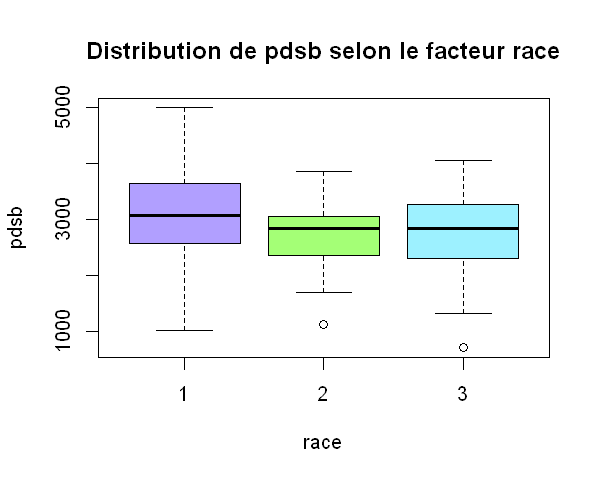

In [9]:
one_factor_model('race', cmap=div_cmap)

Le poids du bébé est en moyenne plus haut pour le niveau 1 (blanc) que pour les deux autres niveaux de `race`.
<br>Le modèle factoriel montre que les poids moyens sont significativement différents (p-value = 0.00681).
<br>Comme l'effet du facteur `race` est significatif, on met en oeuvre la méthode de Bonferroni pour observer les différences entre les niveaux. On peut voir que le niveau 1 (blanc) est significativement différent des niveaux 2 (noir) et 3 (autre), et que les niveaux 2 et 3 ne sont pas significativement différents entre eux.

tabac

Moyennes par niveau :
       0        1 
3054.957 2773.243 

 ANOVA :             Df   Sum Sq Mean Sq F value  Pr(>F)   
get(var)      1  3573406 3573406   6.936 0.00916 **
Residuals   187 96343646  515207                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




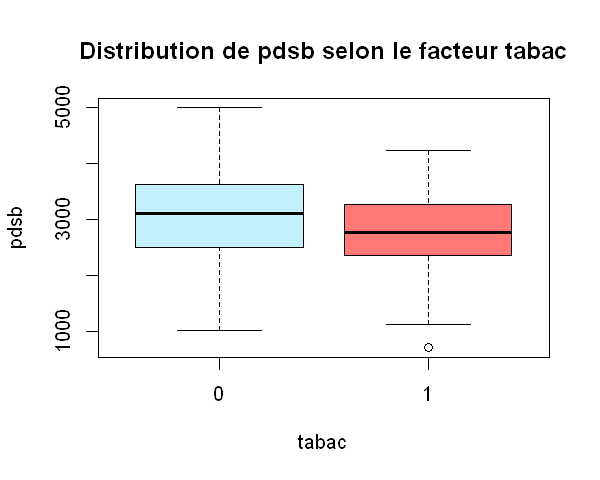

In [10]:
one_factor_model('tabac', cmap=bin_cmap)

Le poids du bébé est en moyenne plus bas pour le niveau représentant les mères ayant fumé pendant la grossesse : 2773.243 pour le niveau 1, contre 3054.957 pour le niveau 0.
<br>Le modèle factoriel montre que les poids moyens sont significativement différents (p-value = 0.00916).

aap

Moyennes par niveau :
       0        1        2 
3013.572 2496.292 2911.833 

 ANOVA :             Df   Sum Sq Mean Sq F value Pr(>F)  
get(var)      1  3024232 3024232   5.837 0.0167 *
Residuals   187 96892821  518143                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Bonferroni :
	Pairwise comparisons using t tests with pooled SD 

data:  pdsb and get(var) 

  0      1     
1 0.0033 -     
2 1.0000 0.6081

P value adjustment method: bonferroni 




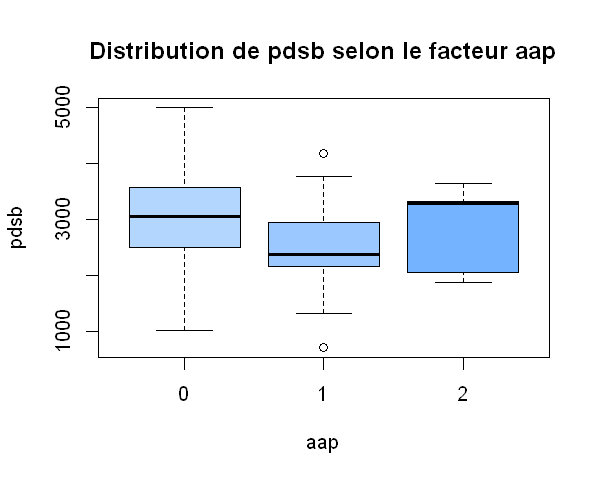

In [11]:
one_factor_model('aap', cmap=grad_cmap)

Le poids du bébé est en moyenne plus bas pour le niveau 1 de `aap` (1 antécédent d'accouchement prématuré).
<br>Le modèle factoriel montre que les poids moyens sont significativement différents (p-value = 0.0167).
<br><br>Comme l'effet du facteur `aap` est significatif, on met en oeuvre la méthode de Bonferroni pour observer les différences entre les niveaux. On peut voir que le niveau 0 est significativement différent du niveau 1, mais pas du niveau 2, et que les niveaux 1 et 2 ne sont pas significativement différents entre eux.

ht

Moyennes par niveau :
       0        1 
2972.311 2536.750 

 ANOVA :             Df   Sum Sq Mean Sq F value Pr(>F)  
get(var)      1  2132014 2132014   4.077 0.0449 *
Residuals   187 97785038  522915                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




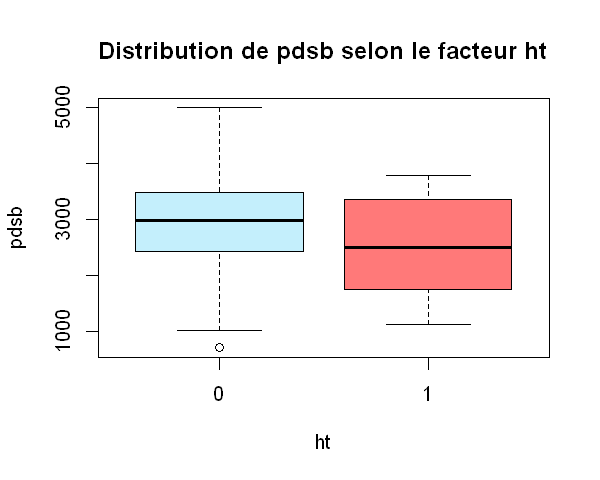

In [12]:
one_factor_model('ht', cmap=bin_cmap)

Le poids du bébé est en moyenne plus bas pour le niveau 1 de `ht` (présence d'hypertension chez la mère). Le modèle factoriel montre que les poids moyens sont significativement différents (p-value = 0.0449).

iu

Moyennes par niveau :
       0        1 
3030.609 2450.429 

 ANOVA :             Df   Sum Sq Mean Sq F value   Pr(>F)    
get(var)      1  8028747 8028747   16.34 7.73e-05 ***
Residuals   187 91888305  491381                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




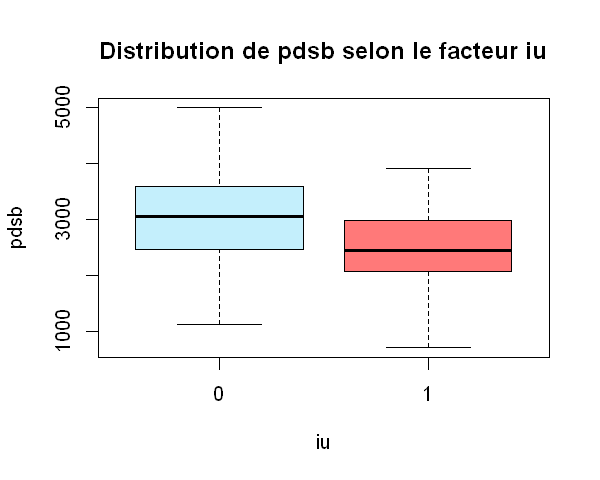

In [13]:
one_factor_model('iu', cmap=bin_cmap)

Le poids du bébé est en moyenne plus bas pour le niveau 1 de `iu` (présence d'irritabilité utérine) : 2450.429, contre 3030.609 pour le niveau 0. Le modèle factoriel montre que les poids moyens sont significativement différents (p-value = 7.73e-05, la plus haute p-value observée dans cette partie).

nbv

Moyennes par niveau :
       0        1        2        3 
2865.270 3108.000 3010.333 2802.250 

 ANOVA :             Df   Sum Sq Mean Sq F value Pr(>F)
get(var)      1   252604  252604   0.474  0.492
Residuals   187 99664449  532965               




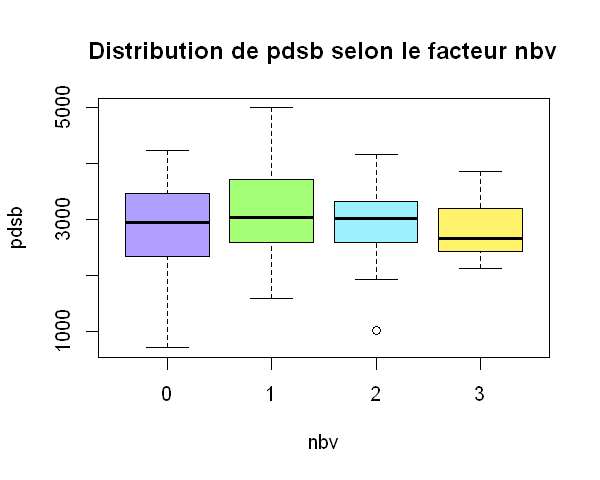

In [14]:
one_factor_model('nbv', cmap=div_cmap)

Pour le facteur `nbv`, les moyennes par niveau présentent des différences, mais le modèle factoriel montre qu'elles ne sont pas significatives.

Suite à cette analyse, on peut retenir 5 facteurs ayant un effet significatif sur `pdsb` : `iu`, `race`, `tabac`, `aap` et `ht` (du plus significatif au moins significatif).

## Modèle additif et évaluation

Nous allons mettre en oeuvre un modèle additif avec ces 5 facteurs.
Comme vu en partie 1.3, le caractère non-complet du plan d'expérience justifie le choix d'un modèle additif, sans interaction.

In [15]:
aov.add <- aov(pdsb ~ race + tabac + aap + ht + iu)
summary(aov.add)

             Df   Sum Sq Mean Sq F value   Pr(>F)    
race          1  3846362 3846362   8.889 0.003260 ** 
tabac         1  7377302 7377302  17.048 5.53e-05 ***
aap           1  1387268 1387268   3.206 0.075029 .  
ht            1  1919085 1919085   4.435 0.036577 *  
iu            1  6197067 6197067  14.321 0.000209 ***
Residuals   183 79189969  432732                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

On remarque que dans ce modèle additif, les variables qui ressortent comme ayant l'effet le plus significatif sont `tabac` et `iu`. Dans ce modèle, `aap` (et même `ht`) ont un effet moins significatif que dans les modèles à un facteur.


	Shapiro-Wilk normality test

data:  aov.add$residuals
W = 0.99377, p-value = 0.6108


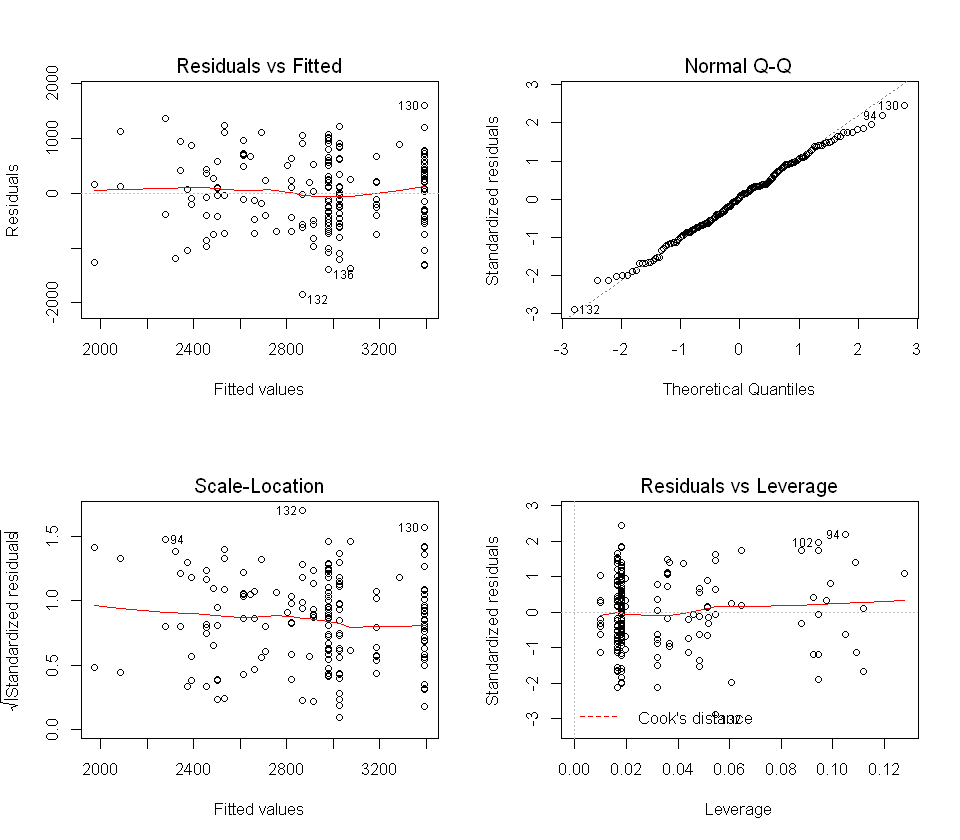

In [16]:
# Model evaluation
options(repr.plot.width=8, repr.plot.height=7)
shapiro.test(aov.add$residuals)
par(mfrow=c(2, 2))
plot(aov.add)

Le test de Shapiro-Wilk renvoie une p-value non significative (supérieure à 0,05). Le modèle satisfait donc l'hypothèse de gaussianité des résidus, ce qui constitue une condition de validation du modèle. Les nuages de points des résidus sont globalement dispersés mais on observe tout de même des concentrations verticales.

# Variables numériques

Dans cette partie nous allons nous intéresser aux variables numériques : `age` et `pdsm`. L'objectif est d'identifier celles que nous pourrons prendre en compte dans l'ANCOVA.

## Analyse des corrélations

In [17]:
rcorr(as.matrix(babyweight[, c('pdsb', num_vars)]))  # 'Hmisc' library

     pdsb  age pdsm
pdsb 1.00 0.09 0.19
age  0.09 1.00 0.18
pdsm 0.19 0.18 1.00

n= 189 


P
     pdsb   age    pdsm  
pdsb        0.2188 0.0105
age  0.2188        0.0132
pdsm 0.0105 0.0132       

L'étude des corrélations deux-à-deux montre que les coefficients de corrélation sont tous positifs et certains significatifs : `pdsb`/`pdsm`, `pdsm`/`age` ont des p-values inférieures à 0.05. Toutefois, ces coefficients ne sont pas très élevés : le plus élevé est 0.19 entre `pdsb` et `pdsm`.

## Régression linéaire

On met tout de même en oeuvre un modèle de régression linéaire multiple pour voir s'il est possible d'expliquer la variable `pdsb` en fonction des autres variables numériques.
<br>
Comme nous n'avons que deux variables explicatives numériques, il n'est pas nécessaire de mettre en place une démarche de sélection de variables : on peut simplement réaliser une régression linéaire sur les deux variables.

In [18]:
reg <- lm(pdsb ~ age + pdsm)
summary(reg)


Call:
lm(formula = pdsb ~ age + pdsm)

Residuals:
     Min       1Q   Median       3Q      Max 
-2232.84  -500.50    32.13   520.32  1899.26 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2215.760    299.238   7.405 4.43e-12 ***
age            8.021     10.060   0.797   0.4263    
pdsm           8.358      3.486   2.397   0.0175 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 718.9 on 186 degrees of freedom
Multiple R-squared:  0.03781,	Adjusted R-squared:  0.02746 
F-statistic: 3.654 on 2 and 186 DF,  p-value: 0.02776


L'estimation du modèle complet montre que seule la variable `pdsm` est significative quand on prend également en compte `age`. Toutefois, le R² très faible (0.03781) ne nous permet pas de considérer le modèle comme satisfaisant pour expliquer la variable réponse. Ce résultat n'est pas étonnant, étant données les faibles corrélations observées en partie 3.1.

# ANCOVA

Les conclusions tirées de la partie 3 ne nous permettent pas de prouver la pertinence d'un modèle de régression linéaire sur `pdsm` (et encore moins sur `age`). On peut néanmoins mettre en oeuvre une ANCOVA afin de voir si la prise en compte simultanée d'un facteur et d'une variable numérique nous permet d'obtenir un modèle satisfaisant.
<br>On avait identifié `iu`, `race` et `tabac` comme variables ayant les effets les plus significatifs sur `pdsb`. On réalisera donc 3 ANCOVA associant chacune de ces variables à `pdsm`. 

Analysis of Variance Table

Response: pdsb
           Df   Sum Sq Mean Sq F value    Pr(>F)    
iu          1  8028747 8028747 16.6161 6.788e-05 ***
pdsm        1  2076990 2076990  4.2985   0.03953 *  
iu:pdsm     1   421079  421079  0.8715   0.35177    
Residuals 185 89390237  483190                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

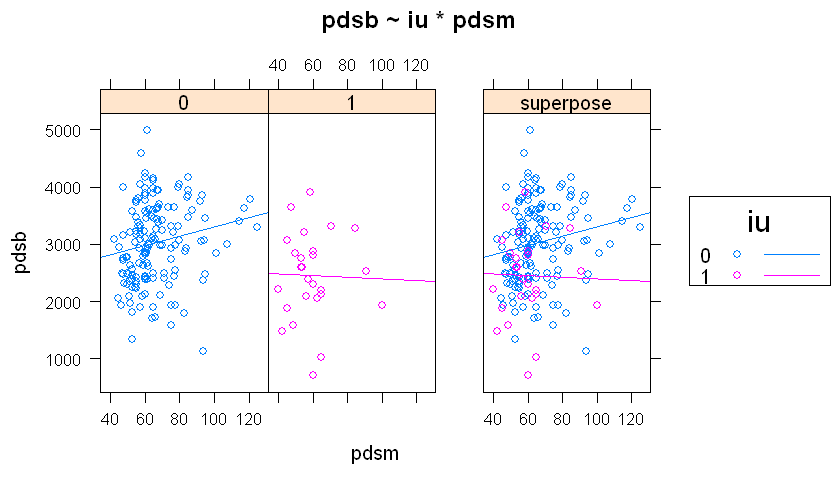

In [19]:
options(repr.plot.width=7, repr.plot.height=4)
ancova(pdsb ~ iu * pdsm, data=babyweight)  # 'HH' library

Analysis of Variance Table

Response: pdsb
           Df   Sum Sq Mean Sq F value   Pr(>F)   
race        2  5070608 2535304  5.0956 0.007022 **
pdsm        1  3499971 3499971  7.0344 0.008698 **
race:pdsm   2   294801  147400  0.2963 0.743956   
Residuals 183 91051673  497550                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

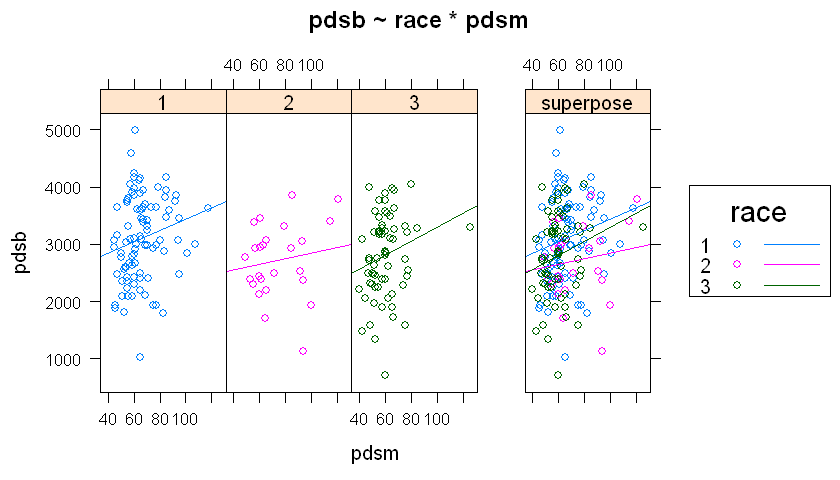

In [20]:
ancova(pdsb ~ race * pdsm, data=babyweight)

Analysis of Variance Table

Response: pdsb
            Df   Sum Sq Mean Sq F value   Pr(>F)   
tabac        1  3573406 3573406  7.1139 0.008327 **
pdsm         1  3151818 3151818  6.2746 0.013112 * 
tabac:pdsm   1   263853  263853  0.5253 0.469515   
Residuals  185 92927975  502313                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

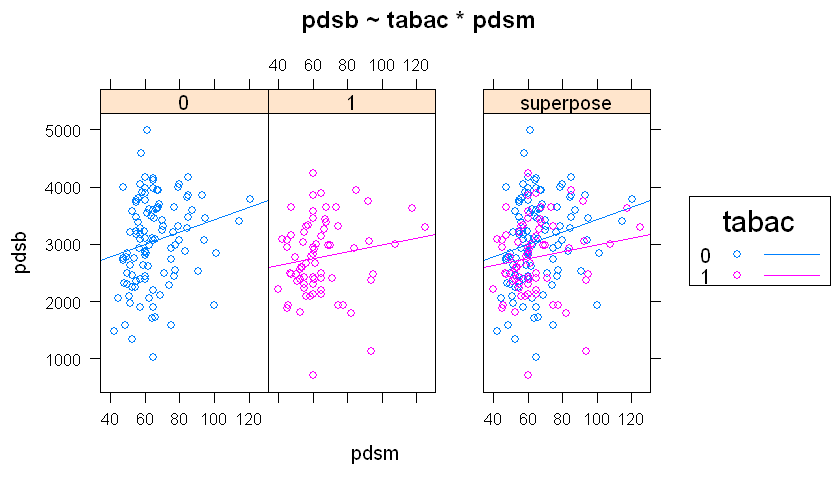

In [21]:
ancova(pdsb ~ tabac * pdsm, data=babyweight)

Dans les 3 cas, même si les p-values semblent significatives, les graphiques ne nous permettent pas de voir des différences nettes entre les différents niveaux des facteurs. On ne peut donc pas affirmer que l'effet de `pdsm` sur `pdsb` est plus ou moins fort selon `iu`, `tabac` ou `race`.

# Conclusion

C'est l'ANOVA qui nous a donné le modèle le plus pertinent pour expliquer le poids du bébé à la naissance. Les facteurs ayant un effet significatif sur `pdsb` sont : `tabac`, `iu`, `race`, `ht` et `aap` (du plus significatif au moins significatif dans le modèle additif).
<br>
On remarque notamment que les niveaux 1 de `tabac`, `iu`, `ht` et `aap`, et les niveaux 2 et 3 de `race`, sont associés à un faible poids du bébé.
<br>
`nbv` n'a pas un effet significatif, tout comme les variables numériques `pdsm` et `age`.